In [23]:
RANDOM_SEED = 2004
EPS = 0.001
ENSEMBLE_NUM = 5
USE_GPU = True

N_ITER = 10
OPTIMIZE = "RMSE"

## Import Library

In [24]:
import re
import random
import math

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import *
from pycaret.regression import *

pd.set_option('mode.chained_assignment', None)
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

## Set Random Seed

In [25]:
def random_seed(RANDOM_SEED):
    random.seed(RANDOM_SEED)
    np.random.seed(RANDOM_SEED) 
    print('Random Seed : {0}'.format(RANDOM_SEED))
    
random_seed(RANDOM_SEED)

Random Seed : 2004


## Load Data

In [26]:
df = pd.read_csv("./중구_결합데이터_최종_교통전력량.csv", encoding='cp949')
df = df.drop('일시', axis=1)

In [27]:
df.describe()

,온도 차,평균기온(°C),일강수량(mm),평균 풍속(m/s),이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥),평균 상대습도(%),평균 현지기압(hPa),합계 일조시간(hr),합계 일사량(MJ/m2),평균 전운량(1/10),도심 교통량,서울시 교통량,계량값,평균 지면온도(°C)
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2.592000e+03,2592.000000,2592.000000
mean,0.521798,12.113387,2.579668,2.063040,0.029326,0.026408,0.500563,0.003508,39.058642,22.877701,60.575193,1006.236150,6.678009,13.867172,4.802238,406504.109375,4.404307e+06,14.381242,14.812693
std,0.996365,10.486494,10.178763,1.046344,0.012941,0.013368,0.172038,0.001192,25.917089,14.139901,15.072627,7.987303,3.978672,7.118099,3.077616,78676.915996,5.242611e+05,12.687477,11.433050
min,-2.300000,-16.500000,0.000000,0.100000,0.006000,0.001000,0.100000,0.001000,3.000000,1.000000,17.900000,981.000000,0.000000,0.020000,0.000000,0.000000,8.564400e+04,1.112971,-9.300000
25%,-0.200000,3.600000,0.000000,1.300000,0.019000,0.017000,0.400000,0.003000,24.000000,13.000000,49.300000,999.800000,3.100000,8.367500,2.100000,356361.000000,4.135928e+06,2.438398,3.800000
50%,0.500000,13.000000,0.000000,1.900000,0.027000,0.026000,0.500000,0.003000,34.000000,20.000000,60.500000,1006.400000,7.800000,13.120000,4.800000,409382.500000,4.481790e+06,9.408975,15.100000
75%,1.200000,21.300000,0.000000,2.700000,0.038000,0.035350,0.600000,0.004000,48.000000,29.000000,70.900000,1012.600000,9.700000,19.152500,7.400000,461304.750000,4.773005e+06,28.350206,25.100000
max,4.300000,32.200000,154.500000,8.400000,0.089000,0.077500,1.400000,0.011000,497.000000,122.000000,99.300000,1026.800000,13.700000,31.190000,10.000000,646394.000000,5.476970e+06,39.828215,40.100000


In [28]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=RANDOM_SEED)

## Preprocess

In [29]:
MEAN = {}
STD = {}

for col_name in df.columns:
    mean = np.mean(train_df[col_name])
    std = np.std(train_df[col_name])
    
    MEAN[col_name] = mean
    STD[col_name] = std
    
    train_df[col_name] = (train_df[col_name]-mean)/std
    test_df[col_name] = (test_df[col_name]-mean)/std

In [30]:
df.describe()

,온도 차,평균기온(°C),일강수량(mm),평균 풍속(m/s),이산화질소농도(ppm),오존농도(ppm),일산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥),평균 상대습도(%),평균 현지기압(hPa),합계 일조시간(hr),합계 일사량(MJ/m2),평균 전운량(1/10),도심 교통량,서울시 교통량,계량값,평균 지면온도(°C)
count,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2592.000000,2.592000e+03,2592.000000,2592.000000
mean,0.521798,12.113387,2.579668,2.063040,0.029326,0.026408,0.500563,0.003508,39.058642,22.877701,60.575193,1006.236150,6.678009,13.867172,4.802238,406504.109375,4.404307e+06,14.381242,14.812693
std,0.996365,10.486494,10.178763,1.046344,0.012941,0.013368,0.172038,0.001192,25.917089,14.139901,15.072627,7.987303,3.978672,7.118099,3.077616,78676.915996,5.242611e+05,12.687477,11.433050
min,-2.300000,-16.500000,0.000000,0.100000,0.006000,0.001000,0.100000,0.001000,3.000000,1.000000,17.900000,981.000000,0.000000,0.020000,0.000000,0.000000,8.564400e+04,1.112971,-9.300000
25%,-0.200000,3.600000,0.000000,1.300000,0.019000,0.017000,0.400000,0.003000,24.000000,13.000000,49.300000,999.800000,3.100000,8.367500,2.100000,356361.000000,4.135928e+06,2.438398,3.800000
50%,0.500000,13.000000,0.000000,1.900000,0.027000,0.026000,0.500000,0.003000,34.000000,20.000000,60.500000,1006.400000,7.800000,13.120000,4.800000,409382.500000,4.481790e+06,9.408975,15.100000
75%,1.200000,21.300000,0.000000,2.700000,0.038000,0.035350,0.600000,0.004000,48.000000,29.000000,70.900000,1012.600000,9.700000,19.152500,7.400000,461304.750000,4.773005e+06,28.350206,25.100000
max,4.300000,32.200000,154.500000,8.400000,0.089000,0.077500,1.400000,0.011000,497.000000,122.000000,99.300000,1026.800000,13.700000,31.190000,10.000000,646394.000000,5.476970e+06,39.828215,40.100000


## Model Selection

In [31]:
reg = setup(train_df, test_data=test_df, target = '온도 차', use_gpu=False)
reg

,Description,Value
0,Session id,8744
1,Target,온도 차
2,Target type,Regression
3,Original data shape,"(2592, 19)"
4,Transformed data shape,"(2592, 19)"
5,Transformed train set shape,"(2332, 19)"
6,Transformed test set shape,"(260, 19)"
7,Numeric features,18
8,Preprocess,True
9,Imputation type,simple


In [32]:
best_models = compare_models(sort=OPTIMIZE, n_select=ENSEMBLE_NUM)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.4544,0.3470,0.5883,0.6505,0.2847,1.4675,2.6360
lightgbm,Light Gradient Boosting Machine,0.4695,0.3663,0.6045,0.6301,0.2932,1.5306,0.6710
gbr,Gradient Boosting Regressor,0.4772,0.3797,0.6157,0.6168,0.2978,1.4325,0.1380
et,Extra Trees Regressor,0.4739,0.3807,0.6162,0.6168,0.3004,1.3500,0.1530
rf,Random Forest Regressor,0.4796,0.3865,0.6211,0.6103,0.3008,1.4005,0.4460
xgboost,Extreme Gradient Boosting,0.4960,0.4005,0.6317,0.5963,0.3030,1.6012,0.4330
ridge,Ridge Regression,0.4937,0.4047,0.6352,0.5928,0.3024,1.4290,0.0090
lr,Linear Regression,0.4938,0.4047,0.6352,0.5928,0.3023,1.4334,0.0100
br,Bayesian Ridge,0.4936,0.4050,0.6355,0.5925,0.3027,1.4212,0.0100
huber,Huber Regressor,0.4938,0.4057,0.6360,0.5917,0.3010,1.4613,0.0120


## Train

In [33]:
topN = [rank for rank in best_models]
tuned_topN = [tune_model(i, n_iter=N_ITER) for i in topN]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4412,0.3375,0.5809,0.6603,0.2978,1.3978
1,0.4558,0.3262,0.5711,0.6198,0.2959,1.7523
2,0.4874,0.3988,0.6315,0.6509,0.2898,1.1054
3,0.4303,0.3037,0.5511,0.6598,0.2703,1.8017
4,0.4703,0.3693,0.6077,0.5804,0.2670,1.6346
5,0.4856,0.3831,0.6190,0.6395,0.2875,1.8416
6,0.4795,0.3685,0.6070,0.6292,0.3012,1.5928
7,0.4907,0.4189,0.6472,0.6356,0.2973,1.4898
8,0.4578,0.3890,0.6237,0.6283,0.2846,1.1487


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4585,0.3715,0.6095,0.6260,0.2994,1.3922
1,0.4587,0.3282,0.5729,0.6175,0.2915,1.8752
2,0.4867,0.3923,0.6263,0.6566,0.2981,1.0761
3,0.4283,0.3070,0.5540,0.6562,0.2680,1.8838
4,0.4600,0.3533,0.5944,0.5987,0.2819,1.5815
5,0.4586,0.3549,0.5957,0.6660,0.2795,1.8384
6,0.4881,0.3939,0.6276,0.6036,0.2976,1.6243
7,0.5018,0.4386,0.6623,0.6184,0.3027,1.5952
8,0.4718,0.3841,0.6198,0.6330,0.2900,1.2028


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4660,0.3837,0.6195,0.6137,0.3082,1.4204
1,0.4719,0.3487,0.5905,0.5935,0.2963,1.7454
2,0.4959,0.4064,0.6375,0.6442,0.2999,1.0918
3,0.4303,0.3080,0.5550,0.6551,0.2598,1.7265
4,0.4672,0.3639,0.6032,0.5866,0.2863,1.9417
5,0.4908,0.3856,0.6210,0.6371,0.2972,1.9585
6,0.4942,0.3854,0.6208,0.6122,0.2955,1.7459
7,0.5077,0.4533,0.6733,0.6056,0.2973,1.5341
8,0.4667,0.3507,0.5922,0.6649,0.2823,1.1352


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5077,0.4389,0.6625,0.5583,0.3491,1.1726
1,0.4710,0.3497,0.5914,0.5923,0.3128,1.4046
2,0.5510,0.4847,0.6962,0.5757,0.3449,1.0716
3,0.4671,0.3670,0.6058,0.5890,0.2925,1.4373
4,0.5040,0.4085,0.6391,0.5359,0.3059,1.4862
5,0.5144,0.4158,0.6448,0.6087,0.3186,1.6598
6,0.5025,0.4056,0.6369,0.5918,0.3150,1.5249
7,0.5155,0.4659,0.6826,0.5946,0.3160,1.2296
8,0.4864,0.4166,0.6454,0.6020,0.3078,1.1666


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.5228,0.4631,0.6805,0.5339,0.3493,1.1375
1,0.4821,0.3687,0.6072,0.5702,0.3127,1.4943
2,0.5676,0.4971,0.7051,0.5648,0.3502,1.1145
3,0.4777,0.3824,0.6184,0.5718,0.3002,1.5027
4,0.5233,0.4290,0.6550,0.5126,0.3105,1.4772
5,0.5359,0.4474,0.6689,0.5790,0.3321,1.6496
6,0.5185,0.4299,0.6556,0.5674,0.3206,1.5542
7,0.5529,0.5099,0.7141,0.5564,0.3313,1.3387
8,0.5061,0.4472,0.6687,0.5728,0.3175,1.1749


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [34]:
blended = blend_models(estimator_list = tuned_topN,
                       fold = 10,
                       optimize=OPTIMIZE,
                       )

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.4457,0.3421,0.5849,0.6556,0.3094,1.2160
1,0.4421,0.3141,0.5604,0.6339,0.2966,1.5463
2,0.4969,0.4010,0.6332,0.6490,0.3095,1.1255
3,0.4218,0.2934,0.5417,0.6714,0.2632,1.6523
4,0.4651,0.3495,0.5912,0.6029,0.2820,1.4864
5,0.4734,0.3587,0.5989,0.6624,0.2940,1.7951
6,0.4512,0.3476,0.5896,0.6502,0.2828,1.3794
7,0.4802,0.4079,0.6387,0.6451,0.2911,1.4033
8,0.4346,0.3513,0.5927,0.6644,0.2733,1.1054


In [35]:
final_model = finalize_model(blended)

## Evaluate

In [47]:
pred = predict_model(final_model, data = test_df)
pred = pred.loc[:, ["온도 차", "prediction_label"]]
pred = pred.apply(lambda x : x*STD["온도 차"]+MEAN["온도 차"])

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,0.1883,0.0611,0.2473,0.9380,0.1339,0.6635


In [48]:
def diff(a, b):
    return math.sqrt((b - a)**2)

pred['MAE'] = pred.apply(lambda x: abs(x['온도 차']-x['prediction_label']), axis=1)
pred

,온도 차,prediction_label,MAE
670,1.6,1.333192,0.266808
2328,0.7,0.366797,0.333203
2461,1.9,1.617139,0.282861
659,0.4,0.473662,0.073662
488,0.8,0.774796,0.025204
...,...,...,...
613,1.6,1.487617,0.112383
888,0.9,0.692839,0.207161
937,1.1,0.863561,0.236439
2221,0.1,0.195532,0.095532


In [49]:
pred.describe()

,온도 차,prediction_label,MAE
count,260.000000,260.000000,260.000000
mean,0.503462,0.513376,0.187690
std,0.992145,0.873667,0.160096
min,-2.000000,-1.659993,0.001399
25%,-0.300000,-0.139055,0.067216
50%,0.500000,0.539545,0.153785
75%,1.125000,1.166903,0.263639
max,3.000000,2.526583,0.896453


In [50]:
rmse_score = np.sqrt(np.mean(((pred['온도 차']-pred['prediction_label'])**2).to_numpy()))
mae_score = np.mean(np.abs(pred['온도 차']-pred['prediction_label']).to_numpy())

In [51]:
print("Average of RMSE : {:.4f}℃".format(rmse_score))
print("Average of MAE : {:.4f}℃".format(mae_score))

Average of RMSE : 0.2465℃
Average of MAE : 0.1877℃


## Visualize

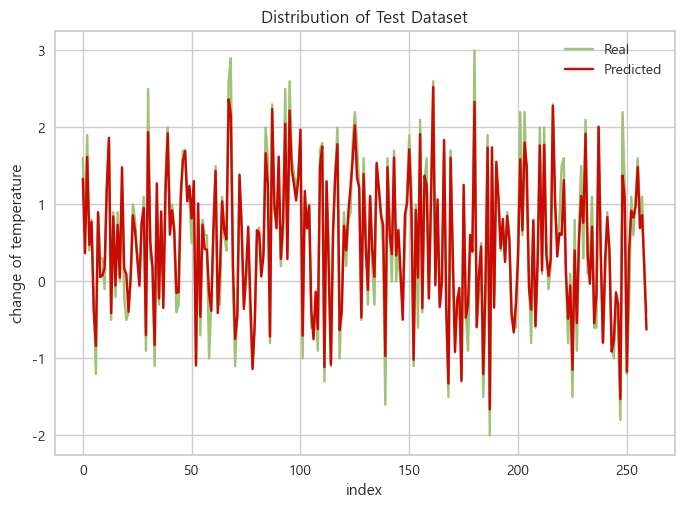

In [41]:
plt.plot(list(pred['온도 차']), '-g',label="Real")
plt.plot(list(pred['prediction_label']), '-r', label="Predicted")
plt.title("Distribution of Test Dataset")
plt.xlabel("index")
plt.ylabel("change of temperature")
plt.legend()
plt.show()

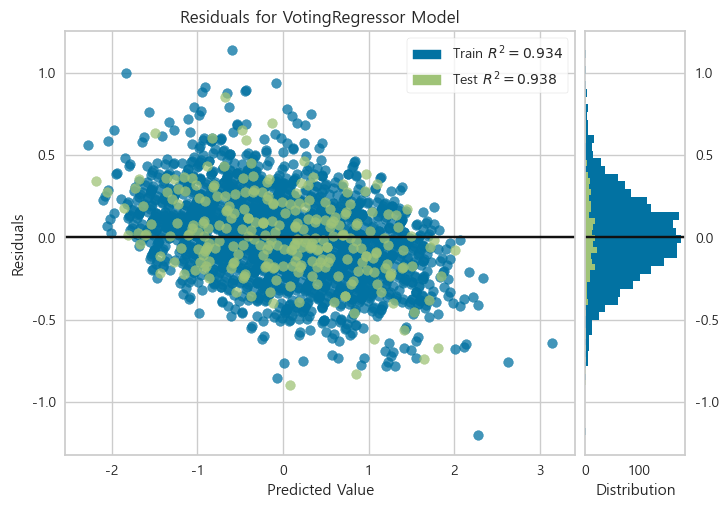

In [42]:
plot_model(final_model)

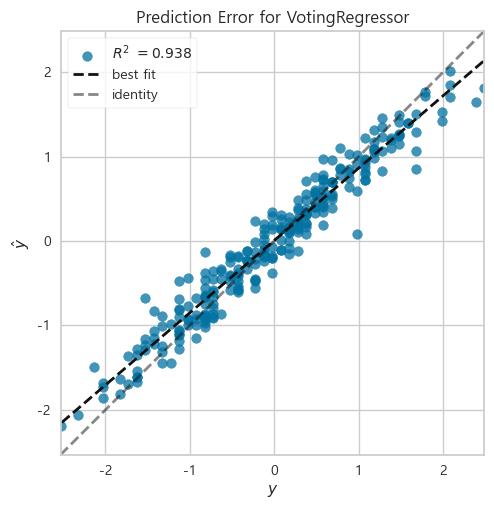

In [43]:
plot_model(final_model, plot="error")

In [44]:
evaluate_model(final_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…